In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from value import Value
from nn import Neuron, Layer, MLP

In [2]:
# some polynomial function
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

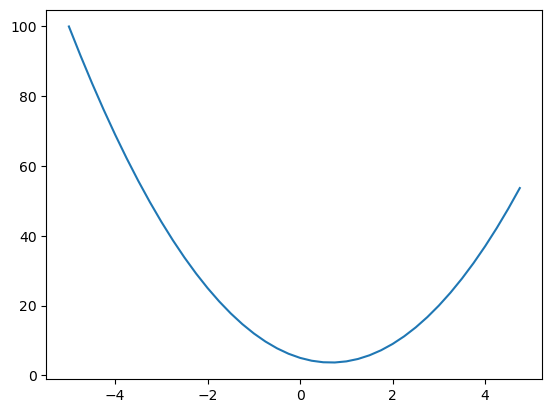

In [3]:
# plot the function
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [4]:
# trivial demonstration of derivation
h = 0.00001
x = 2/3
(f(x + h) - f(x))/h

3.0000002482211127e-05

In [5]:
# demonstration of derivation w.r.t. multiple variables
def g(a, b, c):
    return a*b + c

a = 2.0
b = -3.0
c = 10.0
inputs = [a, b, c]

d1 = g(*inputs)

for i in range(3):
    adj_inputs = inputs.copy()
    adj_inputs[i] += h
    d2 = g(*adj_inputs)
    print('slope w.r.t.', chr(ord('a') + i), (d2 - d1)/h)

slope w.r.t. a -3.000000000064062
slope w.r.t. b 2.0000000000131024
slope w.r.t. c 0.9999999999621422


In [6]:
# definition of scalar value; see scalar.py

In [7]:
# scalar graph visualization routine
from graphviz import Digraph
def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

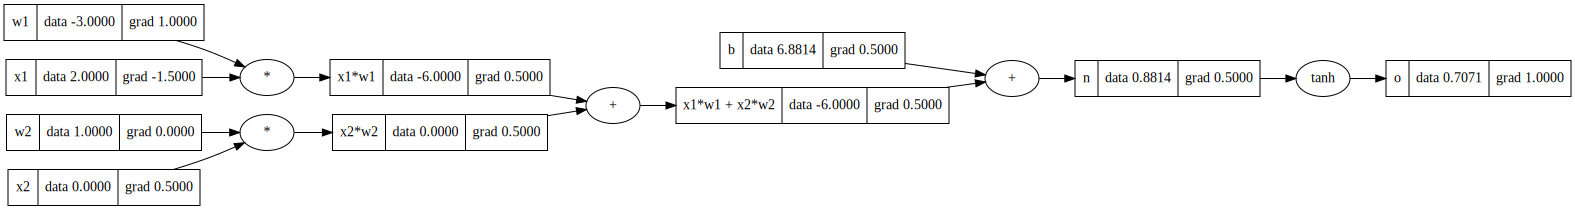

In [8]:
# a two-input/weight neuron with some bias
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# the neuron and its sigmoid activation/squashing function
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

# back-propagate and render
o.backward()
draw_dot(o)

In [9]:
# build a roughly-equivalent neuron in pytorch
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [10]:
# definition of nn (neuron, layer, mlp); see nn.py

In [11]:
# generate basic multilayer perceptron
# 3 input neurons, two hidden layers of 4, and a single output
n = MLP(3, [4, 4, 1])
o = n([2.0, 3.0, -1.0])

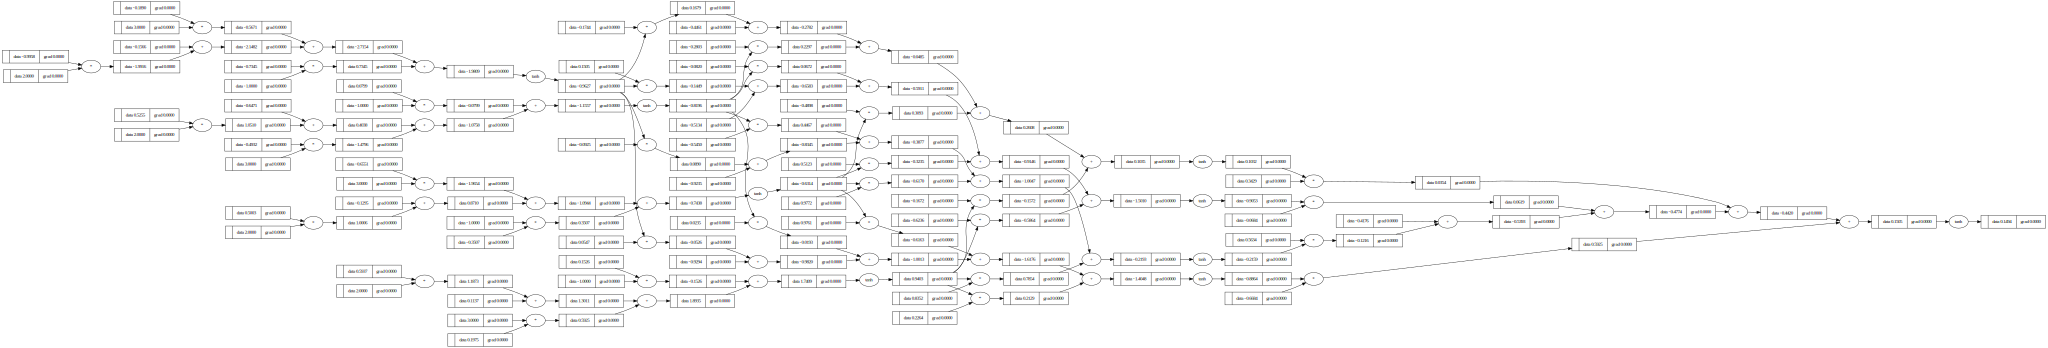

In [12]:
# visualize the whole mlp
draw_dot(o)

In [13]:
# 4-sample/input dataset
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# target outputs, index-matched
ys = [1.0, -1.0, -1.0, 1.0]

In [14]:
# perform iterative gradient descent with sample set

for k in range(1000):
    # forward for each sample input
    ypred = [n(x) for x in xs]

    # iterate through each prediction/actual pair and compute
    # the mean squared error for the whole batch
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward (note: combined network of all 4 samples and loss fn,
    #           which enables gradient descent for all samples and
    #           our loss function)
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update (nudge all parameters in direction of our desired output)
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    # print(k, loss.data)

ypred

[Value(v=0.98657434794764, g=-0.02685130410472003),
 Value(v=-0.9915079279670641, g=0.016984144065871787),
 Value(v=-0.9792466430593845, g=0.04150671388123106),
 Value(v=0.9822635848413809, g=-0.035472830317238246)]